In [1]:
import os
import sys
import time
import math
import logging
import functools
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

from dataset.mydataset import mydataset

from utils import plot_loss, plot_score
from langevin import condition_langevin_dynamics

from statistic.rdc import rdc

from model.cscore_model import cMLP, cScore
from runner.cscore_matching import cscore_matching

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def generate_multigaussian(n, d):
    samples = np.random.multivariate_normal(np.zeros(d),np.eye(d),n)
    samples = np.reshape(samples,(n,d))
    return samples
    
def normalize(fX):
    fXn = (fX - fX.min())/(fX.max()-fX.min())
    return fXn

def tranform(x):
    return np.log(x)-np.log(1-x)

def re_transform(x):
    return 1/(1+np.exp(-x))

def same(x):
    return x

def cube(x):
    return np.power(x, 3)

def negexp(x):
    return np.exp(-np.abs(x))


def fselect(I1):
    if I1 == 1:
        f = same
    elif I1 == 2:
        f = np.square
    elif I1 == 3:
        f = np.cos
    elif I1 == 4:
        f = np.tanh
    elif I1 == 5:
        f = negexp
    return f


def plot_gensample(cscore, X_numpy, Z_numpy, eps=0.1, n_steps=100, re_trans=True, return_sample_only = True):
    x = torch.randn_like(torch.Tensor(X_numpy)).to(device)
    z = torch.Tensor(Z_numpy).to(device)
    x0 = condition_langevin_dynamics(cscore, x, z, eps=eps, n_steps=n_steps)
    
    if not return_sample_only:
        fig = plt.figure(figsize = (3,2))
        if re_trans:
            sns.distplot(re_transform(x0.cpu().numpy()))
            sns.distplot(re_transform(X_numpy))
        else:
            sns.distplot(x0.cpu().numpy())
            sns.distplot(X_numpy)       
        plt.show()
    
    if re_trans:
        return re_transform(x0.cpu().numpy())
    else:
        return x0.cpu().numpy()


def rdc_permtest(cscore, X_numpy, Y_numpy, Z_numpy, eps=0.1, n_steps=100, B = 100, re_trans=True):
    
    resample = []
    for i in range(B):
        x = torch.randn_like(torch.Tensor(X_numpy)).to(device)
        z = torch.Tensor(Z_numpy).to(device)
        x0 = condition_langevin_dynamics(cscore, x, z, eps=eps, n_steps=n_steps)
        resample.append(x0)

    rdc_list = []
    resample_cpu = torch.cat(resample).detach().cpu().numpy()
    l = len(Y_numpy)
    for j in range(B):
        xp = resample_cpu[l*j:l*(j+1)]
        if re_trans:
            rdc_list.append(rdc(re_transform(xp), re_transform(Y_numpy))) 
        else:
            rdc_list.append(rdc(xp, Y_numpy)) 
            
    if re_trans:    
        rho = rdc(re_transform(X_numpy), re_transform(Y_numpy))
    else:
        rho = rdc(X_numpy, Y_numpy)
        
    return rdc_list, rho

def SGMCIT(X, Y, Z, ratio, return_gen = False):
    Z_train = Z[:ratio]
    Y_train = Y[:ratio]
    X_train = X[:ratio]
    Z_test = Z[ratio:]
    Y_test = Y[ratio:]
    X_test = X[ratio:]

    xz_train = np.concatenate((X_train,Z_train),1)
    xz_test = np.concatenate((X_test,Z_test),1)
    xz_train_data = torch.Tensor(xz_train)
    xz_test_data = torch.Tensor(xz_test)

    # print("dx,dy,dz",(dx,dy,dz)) # shape of x,y and z

    xz_train_dataset = mydataset(xz_train_data)
    xz_test_dataset = mydataset(xz_test_data)
            
    net_xz = cMLP(input_dim=dx+dz, output_dim=dx, units = [64,64]).to(device)
    model_xz = cScore(net_xz).to(device)
    ScM_xz = cscore_matching(model_xz, device, dx = dx, dz = dz, learning_rate = 1e-4)

    ScM_xz.load_data(xz_train_dataset, xz_test_dataset, batch_size = 50)
    ScM_xz.train(epoch=100, debug=0)

    gen = plot_gensample(ScM_xz.model.score, X_train, Z_train, eps=0.1, n_steps=200, re_trans=True)

    rdc_l, rho = rdc_permtest(ScM_xz.model.score, X_train, Y_train, Z_train, eps=0.1, n_steps=200, B = 100, re_trans=True)


    rb = np.array(rdc_l)
    p_rdc = len(rb[rb>rho])/len(rb)
    
    if return_gen:
        return gen, p_rdc
    
    return p_rdc
    

In [2]:
dx = 1
dy = 1
dz = 10
n = 1000

normal = True

gau_x_margin_data = []
gau_x_margin_gen = []


for I1 in [1,2,3,4,5]:
    for level in [0.8]:
        results_b = []
        for num in range(1):
            np.random.seed(num) 
            z = generate_multigaussian(n, dz)
            noise_b = generate_multigaussian(n, dx)
            m = np.mean(z,1).reshape(-1,1)
            f1 = fselect(I1)
            x = f1(m + generate_multigaussian(n, dx)+level*noise_b)
            y = f1(m + generate_multigaussian(n, dy)+level*noise_b)

            ratio = n - 1 # ratio1 = n / 2, ratio2 = n - 1 
            
            if normal:
                z = (normalize(z)+0.01)/1.02
                y = (normalize(y)+0.01)/1.02
                x = (normalize(x)+0.01)/1.02
                
            X = tranform(x)
            Y = tranform(y)
            Z = tranform(z)
                
            gen, p_val = SGMCIT(X, Y, Z, ratio, return_gen = True)
        
            
            gau_x_margin_data.append(x)
            gau_x_margin_gen.append(gen)
            
            print(p_val)
                
            

            
            

0.0
0.0
0.02
0.0
0.0


#### Results under Case 4

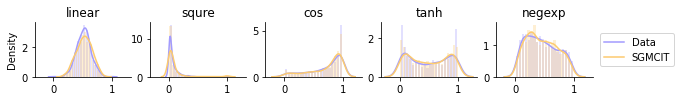

In [3]:
row = 1
col = 5
fig, axs = plt.subplots(row, col, figsize=(10,1.0), sharex=True)
sns.despine(left=False) 
mname = [r'linear', r'squre', r'cos', r'tanh', r'negexp']

for I1 in [1,2,3,4,5]:
    sns.distplot(gau_x_margin_data[I1-1], hist=True, ax=axs[I1-1], bins=20, hist_kws={"histtype": "barstacked", "rwidth":0.8, "linewidth": 0.5,"alpha": 0.3}, color = '#a29bfe')
    sns.distplot(gau_x_margin_gen[I1-1], hist=True, ax=axs[I1-1], bins=20, hist_kws={"histtype": "barstacked", "rwidth":0.8, "linewidth": 0.5,"alpha": 0.3}, color = '#fdcb6e')
    
    axs[I1-1].set_title(mname[I1-1])
    if I1>1:
        axs[I1-1].set(xlabel='', ylabel='')   

plt.legend(["Data", "SGMCIT"], loc='right', bbox_to_anchor=(1.9, 0.5))
plt.show()

In [4]:
dx = 1
dy = 1
dz = 10
n = 1000

normal = True

gau_x_margin_data = []
gau_x_margin_gen = []


for I1 in [1,2,3,4,5]:
    for level in [0]:
        results_b = []
        for num in range(1):
            np.random.seed(num) 
            z = generate_multigaussian(n, dz)
            noise_b = generate_multigaussian(n, dx)

            f1 = fselect(I1)
            x = f1(generate_multigaussian(n, dx)+level*noise_b)
            y = f1(generate_multigaussian(n, dy)+level*noise_b)

            ratio = n - 1 # ratio1 = n / 2, ratio2 = n - 1 
            
            if normal:
                z = (normalize(z)+0.01)/1.02
                y = (normalize(y)+0.01)/1.02
                x = (normalize(x)+0.01)/1.02
                
            X = tranform(x)
            Y = tranform(y)
            Z = tranform(z)
                
            gen, p_val = SGMCIT(X, Y, Z, ratio, return_gen = True)
        
            
            gau_x_margin_data.append(x)
            gau_x_margin_gen.append(gen)
            
            print(p_val)

0.95
0.56
0.57
0.94
0.54


#### Results under Case 1

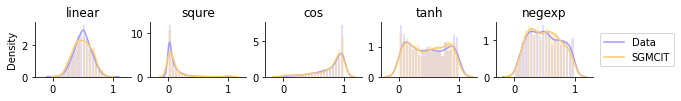

In [5]:
row = 1
col = 5
fig, axs = plt.subplots(row, col, figsize=(10,1.0), sharex=True)
sns.despine(left=False) 
mname = [r'linear', r'squre', r'cos', r'tanh', r'negexp']

for I1 in [1,2,3,4,5]:
    sns.distplot(gau_x_margin_data[I1-1], hist=True, ax=axs[I1-1], bins=20, hist_kws={"histtype": "barstacked", "rwidth":0.8, "linewidth": 0.5,"alpha": 0.3}, color = '#a29bfe')
    sns.distplot(gau_x_margin_gen[I1-1], hist=True, ax=axs[I1-1], bins=20, hist_kws={"histtype": "barstacked", "rwidth":0.8, "linewidth": 0.5,"alpha": 0.3}, color = '#fdcb6e')
    
    axs[I1-1].set_title(mname[I1-1])
    if I1>1:
        axs[I1-1].set(xlabel='', ylabel='')   

plt.legend(["Data", "SGMCIT"], loc='right', bbox_to_anchor=(1.9, 0.5))
plt.show()